# Find Lane lines on the road

In [27]:
# import some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is:  <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


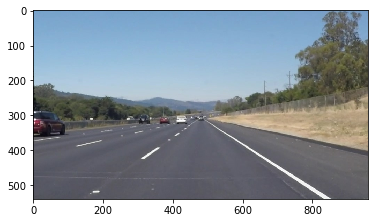

In [28]:
# reading in an image
image = mpimg.imread('images/test 3.jpg')

# printing out some stats and plotting
print('This image is: ', type(image), 'with dimesions:', image.shape)
plt.imshow(image)

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

In [53]:
# belpw are some helper functions to help get you started, They should look familiar from the lesson
import math

def grayscale(img):
    '''
    Applies the Grayscale transform
    This will return an image with only one color channel
    '''
    return cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    '''Applies the Canny transform'''
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img,kernel_size):
    '''Applies a Guassian Noise kernel'''
    return cv2.GaussianBlur(img,(kernel_size,kernel_size),0)

def region_of_interest(img, vertices):
    '''
    Applies an image mask
    
    only keeps the region of the image defined by the polygan formed from 
    `vertices`. The rest of the images is set to black
    '''
    # defining a blank mask to start with
    mask = np.zeros_like(img)
    
    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img,mask)
    return masked_image
    
def draw_lines(img, lines, color=[255,0,0], thickness = 2):
    '''
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    '''
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img,(x1,y1),(x2,y2),color, thickness)
            
def hough_lines(img,rho,theta, threshold, min_line_len, max_line_gap):
    '''
    img: should be the output of a Canny transform,
    
    Returns an image with hough lines drawn
    '''
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength = min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0],img.shape[1],3), dtype=np.uint8)
    draw_lines(line_img,lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ) 

## Test on Images

In [30]:
import os
images = os.listdir('images/')

# Create a directory to save processed images
processed_directory_name = 'processed_images'

if not os.path.exists(processed_directory_name):
    os.mkdir(processed_directory_name)

 run it on all test_images and make copies into the images directory

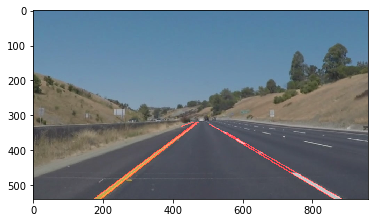

In [56]:
# kernel_size for gaussian blur
kernel_size = 5

# thresholds for canny edge
low_threshold = 60
high_threshold = 140

# Constans for Hough transformation
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 20   # minimum number of votes (intersections in Hough grid cell)
min_line_len = 30 #minimum number of pixels making up a line
max_line_gap = 150    # maximum gap in pixels between connectable line segments

# vertices for polygon with area of interest
left_bottom = [50,539]
right_bottom = [900,539]
apex = [470,320]

vertices = [left_bottom, right_bottom, apex]

def image_process_pipeline(image):
    
    # Convert Grayscale 
    image_grayscale = grayscale(image)
    
    # Apply Gaussian blue
    image_gaussianBlur = gaussian_blur(image_grayscale,kernel_size)
    #plt.imshow(image_gaussianBlur)
    
    # Detect Edges
    image_cannyEdge = canny(image_gaussianBlur, low_threshold, high_threshold)
    #plt.imshow(image_cannyEdge)
    
    # Mask edges to area of interest
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(450, 320), (490, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    image_Mask = region_of_interest(image_cannyEdge, vertices)
    
    # Detect Hough Lines and draw lines on blank image
    image_houghLines = hough_lines(image_Mask, rho, theta, threshold, min_line_len, max_line_gap)
    
    # Draw lines on original image
    image_lineAndEdges = weighted_img(image_houghLines, image)
    
    return image_lineAndEdges

for raw_image in images:
    
    # Read image as matrix
    image = mpimg.imread('images/' +raw_image)
    
    result = image_process_pipeline(image)
    
    # Show processed image
    plt.imshow(result)
    
    # save the image
    mpimg.imsave(os.path.join(processed_directory_name, "processed" +raw_image), result)

## Test on Videos

There two videos provided:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [59]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [60]:
def process_image(image):
    # Note: the output you return should be a color image(3 channel) for processing video below
    result = image_process_pipeline(image)
    return result

In [63]:
white_output = 'white.mp4'
clip1 = VideoFileClip('solidWhiteRight.mp4')
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

t:   3%|██▏                                                                  | 7/221 [00:00<00:03, 66.02it/s, now=None]

Moviepy - Building video white.mp4.
Moviepy - Writing video white.mp4



Moviepy - Done !
Moviepy - video ready white.mp4
Wall time: 2.78 s


In [64]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [65]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   1%|▉                                                                   | 10/681 [00:00<00:07, 95.22it/s, now=None]

Moviepy - Building video yellow.mp4.
Moviepy - Writing video yellow.mp4



Moviepy - Done !
Moviepy - video ready yellow.mp4
Wall time: 7.5 s


In [67]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [68]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   2%|█▎                                                                   | 5/251 [00:00<00:05, 48.53it/s, now=None]

Moviepy - Building video extra.mp4.
Moviepy - Writing video extra.mp4



Moviepy - Done !
Moviepy - video ready extra.mp4
Wall time: 6.3 s


In [69]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))